
# My Pure Pix2Pix Implementation
****

## General Presets

In [1]:
""" Import Packages """

# Numerical Operations
import random
import numpy as np
# Reading/Writing/Cleaning Data
import pandas as pd
from PIL import Image
import os
import gc
# For Progress Bar
from tqdm.auto import tqdm
# For Display
%matplotlib inline
import matplotlib.pyplot as plt
import wandb as wb
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset, random_split
from torchvision.datasets import DatasetFolder, VisionDataset
# my_utilities
import my_utilities


ModuleNotFoundError: No module named 'my_utilities'

In [2]:
""" For Display """

# plt.style.use(r'C:\Users\chael\.matplotlib\violet.mplstyle')
wb.init(project="pure_pix2pix", name="run0")


wandb: Currently logged in as: cullencatniss. Use `wandb login --relogin` to force relogin


In [3]:
""" For Auto-reload Modules"""

%reload_ext autoreload
%autoreload 2

## Configurations

In [5]:
""" Path & Device"""

dataset_name = 'facades/'
task_name = 'facades_pix2pix/'
data_dir, checkpoints_dir, results_dir = 'datasets/' + dataset_name, 'checkpoints/' + task_name, 'results/' + task_name
device = my_utilities.register_device()

In [6]:
""" Preprocessing Rules """

preproc_train = {
	'trans': 'scale & crop',  # | crop | scale width | scale width & crop | none
	'scale_size': 286,  # !!! in TEST TIME set to crop_size !!!
	'crop_size': 256,
	'flip': False  # whether to flip images in augmentation
}
preproc_test = {
	'trans': preproc_train['trans'],
	'scale_size': preproc_train['crop_size'],
	'crop_size': preproc_train['crop_size'],
	'flip': preproc_train['flip']
}

In [7]:
""" Model """

model_name = 'pix2pix'
translate_dirct = 'facade->photo'  # | 'photo->facade'

hp = {
	# ======= network architectures =======
	'G_arch': 'U-net256',  # | U-net128
	'D_arch': 'PatchGAN',  # (for experiments in the paper) | PixelGAN | StdCNN
	'D_layers': 3,
	'in_chan': 3,
	'out_chan': 3,
	'G_fil_num': 64,  # num. of filters in G's first conv. layer
	'D_fil_num': 64,  # num. of filters in D's first conv. layer
	'batch_size': 32,
	'norm_type': 'batch',  # (for experiments in the paper) | instance | none
	'G_dropout': True,
	'W_init_mean': 0,  # mean of distribution input
	'W_init_dev': 0.02,  # deviation of distribution input
	# ============== training ==============
	'epoch_num': 200,
	'shuffle_batch': True,
	'loss_mode': 'vanilla GAN',  # | LSGAN | W-GAN-GP
	'L1_lambda': 100,  # L1's scaler (add L1 to GAN-loss according to the paper)
	'beta1': 0.5,  # momentum for Adam (0.9?)
	'beta2': 0.999,  # momentum for Adam
	'lr': 0.0002,  # initial learning rate for Adam (0.001?)
}

In [8]:
wb.config.update({'translate_dirct': translate_dirct, **preproc_train, **hp})
my_utilities.print_config(device, model_name, translate_dirct,
                          {**preproc_train, **hp})

============CONFIGURATIONS============
Device = cuda
Model = pix2pix
Translation Dirct. = facade->photo
--------------------------------------
Transforms Opt. = scale & crop
Img. Scale Size = 286
Img. Crop Size = 256
Flipped = False
--------------------------------------
G's Arch. = U-net256
D's Arch. = PatchGAN
num. of D's layers = 3
num. of Input's Channels = 3
num. of Output's Channels = 3
simple distribution input:
mean = 0
dev = 0.02
--------------------------------------
Batch Size = 32
Normalization = batch
G's Dropout = True
--------------------------------------
Loss Mode = vanilla GAN
L1's Lambda = 100
Beta1 = 0.5
Initial Learning-rate = 0.0002


## Data Preparation

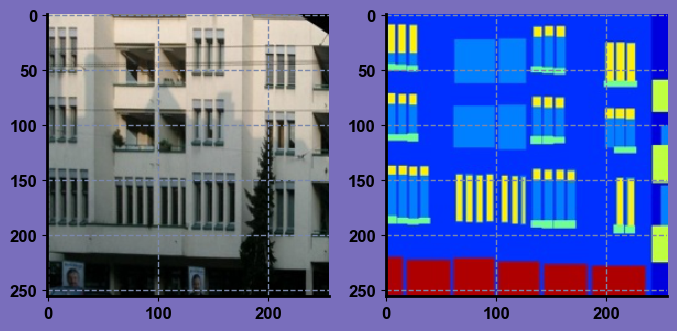

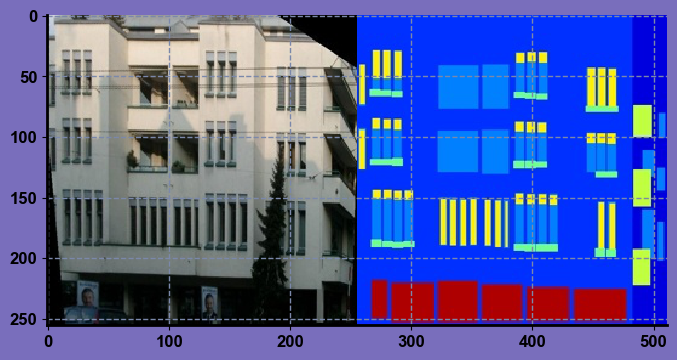

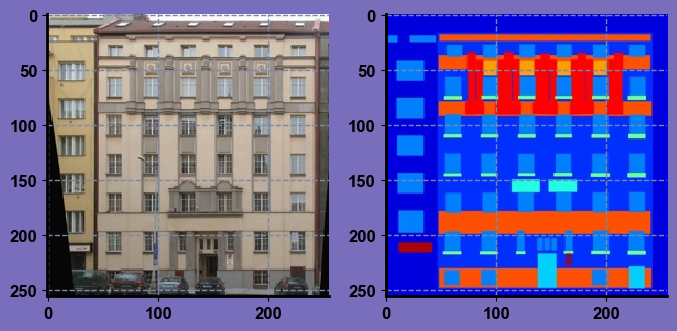

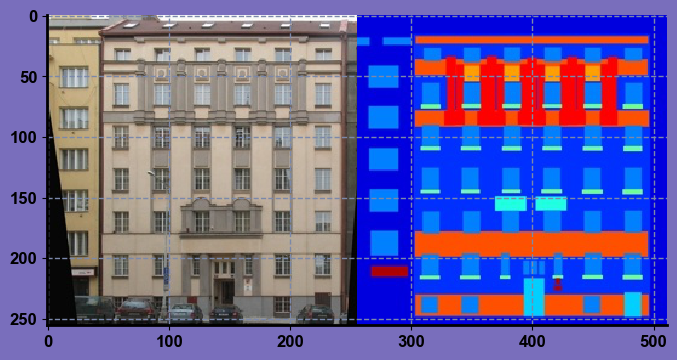

In [9]:
""" Create Dataset (includes split & transforms) """

raw_train_set = my_utilities.read_img(data_dir, 'train')
raw_test_set = my_utilities.read_img(data_dir, 'test')
train_set = my_utilities.Imageset(preproc_train, raw_train_set)
test_set = my_utilities.Imageset(preproc_test, raw_test_set)
train_set.check_preproc(0)
test_set.check_preproc(0)

In [10]:
""" Load data to batches """

train_batches = DataLoader(train_set, hp['batch_size'], hp['shuffle_batch'], pin_memory=True)
test_batches = DataLoader(test_set, hp['batch_size'], hp['shuffle_batch'], pin_memory=True)

## Build Model

In [18]:
""" Init. Weights """


def weights_init(m):
	if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
		nn.init.normal_(m.weight, mean=hp['W_init_mean'], std=hp['W_init_dev'])

### --- Generator ---

In [19]:
""" Define U-net's arch. """


class Unet(nn.Module):
	def __init__(self, img_size=256, in_chan=3, out_chan=3, fst_filters=64, norm='batch', dropout=True, verbose=False):
		"""
		:param img_size: width (or height) of input img.
		:param in_chan: number of input channels
		:param out_chan: number of output channels
		:param fst_filters: number of filters in the first conv.
		:param norm: type of conv.'s normalization
		:param dropout: whether to use dropout
		:param verbose: whether to print messages in the process
		"""
		super().__init__()
		self.encoder = nn.ModuleList()  # a list of layers in encoder
		self.decoder = nn.ModuleList()  # a list of layers in decoder

		self.N = img_size
		self.in_chan = in_chan
		self.out_chan = out_chan
		self.fst_filter = fst_filters
		norm_opt = {'batch': nn.BatchNorm2d, 'instance': nn.InstanceNorm2d}
		self.norm = norm_opt[norm]
		self.dropout = dropout
		self.drop_rate = 0.5
		self.leak_slope = 0.2
		self.F, self.S, self.P = 4, 2, 1  # filter_size, padding_width, step_size
		self.ver = verbose

		self.layers_num = 0
		self.check_layers()
		self.en_res = [None] * self.layers_num

		self.pile_encoder()
		self.pile_decoder()
		self.apply(weights_init)

	def forward(self, X):
		if self.ver: print('=====================================================')
		latent = self.en_forward(X, self.layers_num - 1)
		if self.ver: print('-----------------------------------------------------')
		y = self.de_forward(latent, 0)
		return y

	def check_layers(self):
		while self.N != 1:
			self.N = (self.N - self.F + 2 * self.P) / self.S + 1  # simulate the change of img. size
			assert (self.N - int(self.N) == 0)
			self.layers_num = self.layers_num + 1
		if self.ver: print("Layers num. = " + str(self.layers_num))
		if self.ver: print('=====================================================')

	def pile_encoder(self):
		n = len(self.encoder)
		if n < self.layers_num:
			# set in|out channels
			if n == 0:
				layer_in_chan, layer_out_chan = self.in_chan, self.fst_filter
			elif n < 4:
				layer_in_chan, layer_out_chan = self.fst_filter * (2 ** (n - 1)), self.fst_filter * (2 ** n)
			else:
				layer_in_chan, layer_out_chan = self.fst_filter * 8, self.fst_filter * 8
			# construct layer
			layer = []
			layer += [nn.LeakyReLU(self.leak_slope, inplace=True)] if n != 0 else []
			layer += [
				nn.Conv2d(in_channels=layer_in_chan, out_channels=layer_out_chan, kernel_size=self.F, stride=self.S,
				          padding=self.P)]
			layer += [self.norm(layer_out_chan)] if n != 0 and n != self.layers_num - 1 else []
			# add layer
			self.encoder.append(nn.Sequential(*layer))
			if self.ver: print("En-layer " + str(n) + " added: ", layer_in_chan, "=>",
			                   layer_out_chan)  # layer_no is the index in encoder[]
			# add another
			self.pile_encoder()

		return  # if len(self.encoder)==self.layers_num then the encoder is already intact

	def pile_decoder(self):  # pile decoder reversely for convenience
		n = len(self.decoder)
		if n < self.layers_num:
			# set in|out channels
			if n == 0:
				layer_in_chan, layer_out_chan = 2 * self.fst_filter, self.out_chan
			elif n < 4:
				layer_in_chan, layer_out_chan = 2 * (self.fst_filter * (2 ** n)), self.fst_filter * (2 ** (n - 1))
			elif n == self.layers_num - 1:
				layer_in_chan, layer_out_chan = self.fst_filter * 8, self.fst_filter * 8
			else:
				layer_in_chan, layer_out_chan = 2 * (self.fst_filter * 8), self.fst_filter * 8
			# construct layer
			layer = []
			layer += [nn.ReLU(inplace=True)]
			layer += [nn.ConvTranspose2d(in_channels=layer_in_chan, out_channels=layer_out_chan, kernel_size=self.F,
			                             stride=self.S, padding=self.P)]
			layer += [self.norm(layer_out_chan)] if n != 0 else []
			layer += [nn.Dropout(0.5)] if n != 0 and self.dropout == True else []
			layer += [nn.Tanh()] if n == 0 else []
			# add layer
			self.decoder.append(nn.Sequential(*layer))
			if self.ver: print("De-layer " + str(n) + " added: ", layer_in_chan, "=>", layer_out_chan)
			# add another
			self.pile_decoder()

		return  # if len(self.decoder)==self.layers_num then the reversed decoder is already intact

	def en_forward(self, X, i):
		self.en_res[i] = self.encoder[i](X) if i == 0 else self.encoder[i](self.en_forward(X, i - 1))
		# (reuse self.encoder for inner results of encoder)
		if self.ver: print("En-layer " + str(i) + " done: ", self.en_res[i].size())
		return self.en_res[i]

	def de_forward(self, X, i):
		res = self.decoder[i](X) if i == self.layers_num - 1 else self.decoder[i](self.de_forward(X, i + 1))
		if i != 0: res = torch.cat([res, self.en_res[i - 1]], dim=1)
		if self.ver: print("De-layer " + str(i) + " done: ", res.size())
		return res


""" Create Generator instance """
G = Unet(
	preproc_train['crop_size'],
	hp['in_chan'], hp['out_chan'],
	hp['G_fil_num'], hp['norm_type'], hp['G_dropout']
	, True).to(device)

""" Test implementation """
_, real_facade = train_set.__getitem__(0)
fake_photo = G.forward(real_facade.unsqueeze(0).to(device))

Layers num. = 8
En-layer 0 added:  3 => 64
En-layer 1 added:  64 => 128
En-layer 2 added:  128 => 256
En-layer 3 added:  256 => 512
En-layer 4 added:  512 => 512
En-layer 5 added:  512 => 512
En-layer 6 added:  512 => 512
En-layer 7 added:  512 => 512
De-layer 0 added:  128 => 3
De-layer 1 added:  256 => 64
De-layer 2 added:  512 => 128
De-layer 3 added:  1024 => 256
De-layer 4 added:  1024 => 512
De-layer 5 added:  1024 => 512
De-layer 6 added:  1024 => 512
De-layer 7 added:  512 => 512
En-layer 0 done:  torch.Size([1, 64, 128, 128])
En-layer 1 done:  torch.Size([1, 128, 64, 64])
En-layer 2 done:  torch.Size([1, 256, 32, 32])
En-layer 3 done:  torch.Size([1, 512, 16, 16])
En-layer 4 done:  torch.Size([1, 512, 8, 8])
En-layer 5 done:  torch.Size([1, 512, 4, 4])
En-layer 6 done:  torch.Size([1, 512, 2, 2])
En-layer 7 done:  torch.Size([1, 512, 1, 1])
-----------------------------------------------------
De-layer 7 done:  torch.Size([1, 1024, 2, 2])
De-layer 6 done:  torch.Size([1, 1024,

### --- Discriminator ---
Conditional

In [21]:
""" Define PatchGAN's arch. """


class PatchGAN(nn.Module):
	def __init__(self, img_size=256, in_chan=3 + 3, out_chan=1, fst_filters=64, norm='batch', verbose=False):
		"""
		:param img_size: width (or height) of input img.
		:param in_chan: number of input channels (`condition` cat. `fake`/ `real`)
		:param out_chan: number of output channel(s)
		:param fst_filters: number of filters in the first conv.
		:param norm: type of conv.'s normalization
		:param verbose: whether to print messages in the process
		"""
		super().__init__()
		self.cnn = nn.ModuleList()
		self.N = img_size
		self.in_chan = in_chan
		self.out_chan = out_chan
		self.fst_filter = fst_filters
		norm_opt = {'batch': nn.BatchNorm2d, 'instance': nn.InstanceNorm2d}
		self.norm = norm_opt[norm]
		self.F, self.S, self.SS, self.P = 4, 2, 1, 1  # filter_size, padding_width, step_size
		self.leak_slope = 0.2
		self.layers_num = 5  # 70*70 per Patch of input img.
		self.ver = verbose

		self.pile_cnn()
		self.apply(weights_init)

	def forward(self, X):
		if self.ver: print('=====================================================')
		patch_scores = self.conv_forward(X, self.layers_num - 1)
		# (NO SIGMOID BECAUSE LOSS_FUNC WILL INCLUDE THAT)
		return patch_scores

	def pile_cnn(self):
		n = len(self.cnn)
		if n < self.layers_num:
			# set in|out channels
			layer_in_chan = self.in_chan if n == 0 else self.fst_filter * (2 ** (n - 1))
			layer_out_chan = self.fst_filter * (2 ** n) if n != 4 else self.out_chan
			step_size = self.S if n < 3 else self.SS
			# construct layer
			layer = []
			layer += [nn.Conv2d(layer_in_chan, layer_out_chan, self.F, step_size, self.P)]
			layer += [self.norm(layer_out_chan)] if n != 0 and n != 4 else []
			layer += [nn.LeakyReLU(0.2, inplace=True)] if n != 4 else []
			# add layer
			self.cnn.append(nn.Sequential(*layer))
			if self.ver: print("C-layer " + str(n) + " added: ", layer_in_chan, "=>", layer_out_chan)
			# add another
			self.pile_cnn()

		return  # if len(self.cnn)==self.layers_num then the patchGAN is already intact

	def conv_forward(self, X, i):
		res = self.cnn[i](X) if i == 0 else self.cnn[i](self.conv_forward(X, i - 1))
		if self.ver: print("C-layer " + str(i) + " done: ", res.size())
		return res


""" Create Generator instance """

D = PatchGAN(
	preproc_train['crop_size'],
	hp['in_chan'] + hp['out_chan'], 1,
	hp['D_fil_num'], hp['norm_type'], True).to(device)

""" Test implementation """

real_photo, real_facade = train_set.__getitem__(0)
patch_scores = D.forward(torch.cat((real_facade.unsqueeze(0), real_photo.unsqueeze(0)), dim=1).to(device))

C-layer 0 added:  6 => 64
C-layer 1 added:  64 => 128
C-layer 2 added:  128 => 256
C-layer 3 added:  256 => 512
C-layer 4 added:  512 => 1
C-layer 0 done:  torch.Size([1, 64, 128, 128])
C-layer 1 done:  torch.Size([1, 128, 64, 64])
C-layer 2 done:  torch.Size([1, 256, 32, 32])
C-layer 3 done:  torch.Size([1, 512, 31, 31])
C-layer 4 done:  torch.Size([1, 1, 30, 30])


## Train Model

In [22]:
""" Set Loss func. """


def loss_opt(mode):
	loss_opt = {'vanilla GAN': nn.BCEWithLogitsLoss(), 'LSGAN': nn.MSELoss(), 'W-GAN-GP': None}
	return loss_opt[mode]

### --- Train Discriminator ---

In [24]:
def train_discriminator(D: PatchGAN, G: Unet, batch, dirct, loss_mode, optimizer, device, verbose=False):
	"""
	-- Training process for D
	:param D: discriminator's model instance
	:param G: generator's model instance
	:param batch: each element is of paired data (photo_batches, facade_batches)
	:param dirct: translation direction ('facade->photo'/ 'photo->facade')
	:param loss_mode: loss function's mode
	:param optimizer: optimizer function
	:param device: device
	:param verbose: whether to print messages in the process
	:return: D_loss, the sum of loss of scores for both real & fake imgs.
	"""
	# Prepare Batches
	cond_batch = my_utilities.sub_batch(batch, dirct, 'cond').to(device)  # a batch of conditions
	real_batch = my_utilities.sub_batch(batch, dirct, 'real').to(device)  # a batch of real imgs.
	cat_cond_real = torch.cat((cond_batch, real_batch), dim=1).to(device)
	fake_batch = G(cond_batch)  # generate a batch of fake imgs.
	if verbose: print("Fake imgs. generation done.")
	cat_cond_fake = torch.cat((cond_batch, fake_batch), dim=1).to(device)

	# Set Loss_func
	loss = loss_opt(loss_mode)

	# Forward pass
	D.zero_grad()
	learnt_scores_real = D(cat_cond_real)
	if verbose: print("Learn scores of real imgs. done.")
	true_scores_real = torch.ones(learnt_scores_real.size()).to(device)  # a tensor of '1's
	learnt_scores_fake = D(cat_cond_fake)
	if verbose: print("Learn scores of fake imgs. done.")
	true_scores_fake = torch.zeros(learnt_scores_fake.size()).to(device)  # a tensor of '0's
	real_loss = loss(learnt_scores_real,
	                 true_scores_real) if loss_mode != 'W-GAN-GP' else -learnt_scores_real.mean()
	if verbose: print("Got loss of real_img scores: ", real_loss)
	fake_loss = loss(learnt_scores_fake,
	                 true_scores_fake) if loss_mode != 'W-GAN-GP' else learnt_scores_fake.mean()
	if verbose: print("Got loss of fake_img scores: ", fake_loss)
	D_loss = (real_loss + fake_loss) / 2
	D_loss.backward()
	optimizer.step()
	return D_loss.data.item()


""" Test D-training """

batch = next(iter(train_batches))
train_discriminator(D, G, batch, translate_dirct, hp['loss_mode'],
                    optim.Adam(D.parameters(), lr=hp['lr'],
                               betas=(hp['beta1'], hp['beta2'])), device, True)

En-layer 0 done:  torch.Size([32, 64, 128, 128])
En-layer 1 done:  torch.Size([32, 128, 64, 64])
En-layer 2 done:  torch.Size([32, 256, 32, 32])
En-layer 3 done:  torch.Size([32, 512, 16, 16])
En-layer 4 done:  torch.Size([32, 512, 8, 8])
En-layer 5 done:  torch.Size([32, 512, 4, 4])
En-layer 6 done:  torch.Size([32, 512, 2, 2])
En-layer 7 done:  torch.Size([32, 512, 1, 1])
-----------------------------------------------------
De-layer 7 done:  torch.Size([32, 1024, 2, 2])
De-layer 6 done:  torch.Size([32, 1024, 4, 4])
De-layer 5 done:  torch.Size([32, 1024, 8, 8])
De-layer 4 done:  torch.Size([32, 1024, 16, 16])
De-layer 3 done:  torch.Size([32, 512, 32, 32])
De-layer 2 done:  torch.Size([32, 256, 64, 64])
De-layer 1 done:  torch.Size([32, 128, 128, 128])
De-layer 0 done:  torch.Size([32, 3, 256, 256])
Fake imgs. generation done.
C-layer 0 done:  torch.Size([32, 64, 128, 128])
C-layer 1 done:  torch.Size([32, 128, 64, 64])
C-layer 2 done:  torch.Size([32, 256, 32, 32])
C-layer 3 done:

0.8850108981132507

### --- Train Generator ---

In [25]:
def train_generator(D: PatchGAN, G: Unet, batch, dirct, loss_mode, L1_lambda, optimizer, device, verbose=False):
	"""
	-- Training process for G
	:param D: discriminator's model instance
	:param G: generator's model instance
	:param batch: each element is of paired data (photo_batches, facade_batches)
	:param dirct: translation direction ('facade->photo'/ 'photo->facade')
	:param loss_mode: loss function's mode
	:param L1_lambda: the scalar for L1 term
	:param optimizer: optimizer function
	:param device: device
	:param verbose: whether to print messages in the process
	:return: G_loss, the loss of the generated fake img.
	"""
	# Prepare Batches
	cond_batch = my_utilities.sub_batch(batch, dirct, 'cond').to(device)  # a batch of conditions
	real_batch = my_utilities.sub_batch(batch, dirct, 'real').to(device)  # a batch of real imgs.
	# Set Loss_func
	train_loss = loss_opt(loss_mode)
	reg_loss = nn.L1Loss().to(device)

	# Forward pass
	G.zero_grad()
	fake_batch = G(cond_batch)  # generate a batch of fake imgs.
	if verbose: print("Fake imgs. generation done.")
	cat_cond_fake = torch.cat((cond_batch, fake_batch), dim=1).to(device)
	scores_fake = D(cat_cond_fake)  # input condition & fake img. to D. and get scores
	scores_real = torch.ones(scores_fake.size()).to(device)
	if verbose: print("Learn scores of fake imgs. done.")
	G_train_loss = train_loss(scores_fake, scores_real) if loss_mode != 'W-GAN-GP' else -scores_fake.mean()
	G_reg_loss = reg_loss(fake_batch, real_batch)
	G_loss = G_train_loss + L1_lambda * G_reg_loss
	if verbose: print("Got loss of fake_imgs.: ", G_loss)
	G_loss.backward()
	optimizer.step()
	return G_loss.data.item()


""" Test G-training """

batch = next(iter(train_batches))
train_generator(D, G, batch, translate_dirct, hp['loss_mode'], hp['L1_lambda'],
                optim.Adam(D.parameters(), lr=hp['lr'],
                           betas=(hp['beta1'], hp['beta2'])), device, True)

En-layer 0 done:  torch.Size([32, 64, 128, 128])
En-layer 1 done:  torch.Size([32, 128, 64, 64])
En-layer 2 done:  torch.Size([32, 256, 32, 32])
En-layer 3 done:  torch.Size([32, 512, 16, 16])
En-layer 4 done:  torch.Size([32, 512, 8, 8])
En-layer 5 done:  torch.Size([32, 512, 4, 4])
En-layer 6 done:  torch.Size([32, 512, 2, 2])
En-layer 7 done:  torch.Size([32, 512, 1, 1])
-----------------------------------------------------
De-layer 7 done:  torch.Size([32, 1024, 2, 2])
De-layer 6 done:  torch.Size([32, 1024, 4, 4])
De-layer 5 done:  torch.Size([32, 1024, 8, 8])
De-layer 4 done:  torch.Size([32, 1024, 16, 16])
De-layer 3 done:  torch.Size([32, 512, 32, 32])
De-layer 2 done:  torch.Size([32, 256, 64, 64])
De-layer 1 done:  torch.Size([32, 128, 128, 128])
De-layer 0 done:  torch.Size([32, 3, 256, 256])
Fake imgs. generation done.
C-layer 0 done:  torch.Size([32, 64, 128, 128])
C-layer 1 done:  torch.Size([32, 128, 64, 64])
C-layer 2 done:  torch.Size([32, 256, 32, 32])
C-layer 3 done:

50.06304931640625

# Complete Training Process

In [26]:
optimizer_D = optim.Adam(D.parameters(), lr=hp['lr'],
                         betas=(hp['beta1'], hp['beta2']))
optimizer_G = optim.Adam(G.parameters(), lr=hp['lr'],
                         betas=(hp['beta1'], hp['beta2']))

# save initial generated img.
batch = next(iter(train_batches))
my_utilities.save_gen_chk_point(G, batch, translate_dirct, results_dir, 'train/', 0, device)

# set epoch_num
e_num = hp['epoch_num']

# set mode
G.train()
D.train()

# train loop
D_e_loss, G_e_loss = [], []
# (e_loss: losses of each epoch)
for e in range(e_num):  # iter. epochs
	D_b_loss, G_b_loss, b, batch_avg_loss = [], [], 0, 0
	# (b_loss: losses of each batch)
	for batch in train_batches:  # iter. batches
		b += 1
		D_loss = train_discriminator(D, G, batch, translate_dirct, hp['loss_mode'], optimizer_D, device)
		G_loss = train_generator(D, G, batch, translate_dirct, hp['loss_mode'], hp['L1_lambda'], optimizer_G, device)
		print("epoch ", e + 1, "/", e_num, ".batch ", b, " => D's loss: ", D_loss, "G's loss: ",
		      G_loss)
		# collect batch-loss to batches-loss list
		D_b_loss.append(D_loss)
		G_b_loss.append(G_loss)
	if (e + 1) % 10 == 0 or e + 1 == e_num:
		# save current G.'s result
		idx = (e + 1) // 10
		batch = next(iter(train_batches))
		my_utilities.save_gen_chk_point(G, batch, translate_dirct, results_dir, 'train/', idx, device)
		# collect avg. loss of all batches to epochs-loss list
		avg_D_b_loss = np.array(D_b_loss).mean()
		avg_G_b_loss = np.array(G_b_loss).mean()
		D_e_loss.append(avg_D_b_loss)
		G_e_loss.append(avg_G_b_loss)
		my_utilities.save_model_chk_point(
			checkpoints_dir, e + 1,
			D, G, avg_D_b_loss, avg_G_b_loss,
			optimizer_D, optimizer_G
		)

print("Train-loop done.")

## Test Model

In [1]:
# Load Last Model checkpoint
checkpoint = torch.load(checkpoints_dir + "epoch" + str(e_num // 10) + "_G.pth")
G.load_state_dict(checkpoint['model_state'])

# set mode
G.eval()

with torch.no_grad():
	b = 0
	for batch in test_batches:
		b += 1
		cond_batch = my_utilities.sub_batch(batch, translate_dirct, 'cond')
		real_batch = my_utilities.sub_batch(batch, translate_dirct, 'real')
		gen_batch = G(cond_batch)
		save_image(torch.cat((cond_batch, gen_batch, real_batch), dim=3),
		           results_dir + 'test/' + "result" + str(b) + ".png")



NameError: name 'torch' is not defined